# Movie Recommendation

Exploring serval approaches to building a recommendation system with python

## Set UP

In [1]:
# import some required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%config Completer.use_jedi = False

In [2]:
# Read the data
credits = pd.read_csv('../input/the-movies-dataset/credits.csv')
keywords = pd.read_csv('../input/the-movies-dataset/keywords.csv')
movies = pd.read_csv('../input/the-movies-dataset/movies_metadata.csv', low_memory=False)
ratings = pd.read_csv('../input/the-movies-dataset/ratings_small.csv')

In [3]:
movies.head(5)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


## A Little Expository Data Analysis

#### Movies DataFrame

In [4]:
movies_df = movies.copy() # create a copy for analysis
print(f'The movies meta shape = {movies_df.shape}')
print(movies.columns)
movies.info()

The movies meta shape = (45466, 24)
Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 no

In [5]:
# helper function that checks for columns with missing values and plot them
def check_missing(df):
    size = df.shape[0]
    missing = df.isnull().sum()[df.isnull().sum() > 0].sort_values()
    if not missing.empty:
        if len(missing) <= 3:
            print(missing.to_dict) # return a dict mapping of columns to number of missing values
        else:
            plot_missing(missing, size) # only plot the bar chart if there are more than 3 columns with missing values
    else:
        print('This dataframe has no missing values')
        
def plot_missing(data : pd.Series, size):
    plt.figure(figsize = (10,5))
    plt.style.use('seaborn-darkgrid')
    plt.title('Missing Values Plot')
    ax = data.plot.barh(color = 'green')
    
    for p in ax.patches:
        percentage ='{:,.2f}%'.format((p.get_width()/size)*100)
        width, height =p.get_width(),p.get_height()
        x=p.get_x()+width+0.02
        y=p.get_y()+height/2
        ax.annotate(percentage,(x,y))
    plt.show()

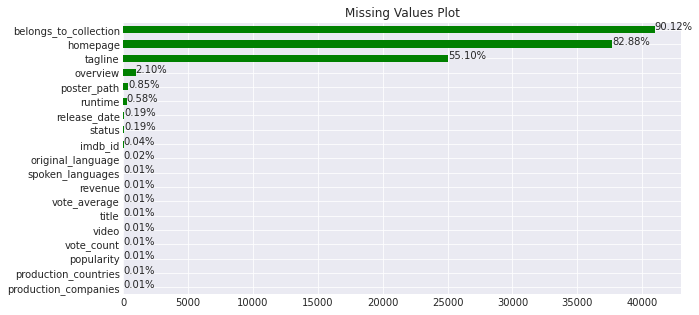

In [6]:
check_missing(movies_df)

#### Questions

1. What are the top rated genres accross the movies dataset?

Number of unique genres in the movies data is 23


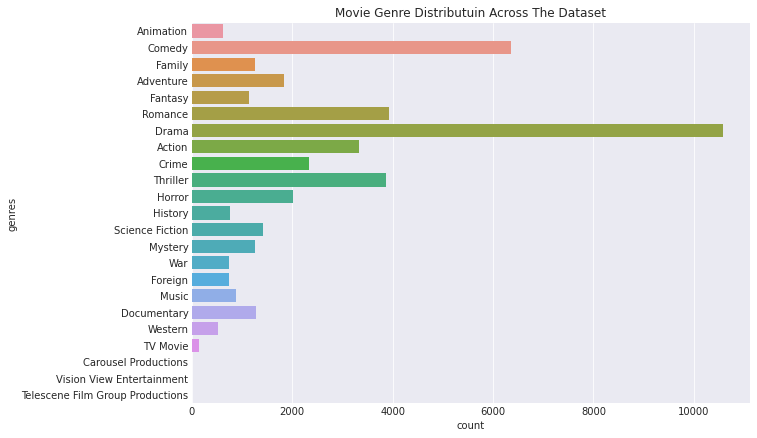

In [7]:
from ast import literal_eval # converts stringified objects to their base objects

def get_genres(x):
    x = literal_eval(x)
    if len(x) > 0:
        return [genre['name'] for genre in x]
    else:
        return []
df = movies_df.copy()
df['genres'] = df['genres'].apply(get_genres).explode('genres')
print(f'Number of unique genres in the movies data is {df.genres.nunique()}')

# get average ratings across genres
genre_r = df.groupby('genres')['vote_average'].mean()

#plot distribution
plt.figure(figsize = (10,7))
sns.countplot(y = 'genres', data = df)
# sns.catplot(y = 'genres', x = 'vote_average', data = df, kind="violin")
#sns.barplot(x = genre_r.values, y= genre_r.index )
plt.title('Movie Genre Distributuin Across The Dataset')
plt.show()

In [8]:
# see top 10 most rated movies
df.sort_values(by = 'vote_count', ascending = False)['title'].head(10)

15480                  Inception
12481            The Dark Knight
14551                     Avatar
17818               The Avengers
26564                   Deadpool
22879               Interstellar
20051           Django Unchained
23753    Guardians of the Galaxy
2843                  Fight Club
18244           The Hunger Games
Name: title, dtype: object

From the above we can see that drama dominates the movies set followed by comedy. We also saw some bad inputs like production companies being listed as genres. If we would be working with the genres column for modelling we ought to remove those.

2. Get the most liked movies.

For the problem, we wont just select the movie with the highest vote_average. The idea is that a movie rated 4.8 by 200 users should not be placed below that rated 5 by 3 persons. We will therefore use some weighted formular that incorporates both vote_average and count to get most liked movies. 

IMDB already has one, lets use it.
$$WeightedRating = (\frac{v}{v+m} * R) + (\frac{m}{v+m} * C) $$
where v = vote_count, R = movie_rating, m = minimum number of votes required for the
movie to be in the chart (we set this), C = mean rating of all the movies in the dataset

In [9]:
# get the most liked movies
def get_most_rated(df, m = None, n = 10):
    """
    Gets the most rated movies based on the formula above
    
    inputs:
        df (pd.DataFrame): movies data must include title, vote_average and vote_count columns
        m (int): minimum number of votes required for a movie to be considered
        n (int) : Top n movies to return
        
    Returns:
        ratings (pd.DataFrame) : a series containing the top n rated movies
    
    """
    if m == None:
        m = df['vote_count'].quantile(0.80) # takes the 80 percentile value
    C = df['vote_average'].mean()
    def get_rating(x, m = m, C = C):
        v = x['vote_count']
        R = x['vote_average']
        return (v/(v+m) * R) + (m/(m+v) * C)
    pop_movies = df.loc[:, ['title', 'vote_count', 'vote_average']]
    pop_movies['score'] = pop_movies.apply(get_rating, axis = 1)
    pop_movies = pop_movies.sort_values(by = 'score', ascending = False).reset_index(drop = True)
    return pop_movies.head(n)
    
get_most_rated(movies_df, m = None, n = 10)

,title,vote_count,vote_average,score
0,Dilwale Dulhania Le Jayenge,661.0,9.1,8.855148
1,The Shawshank Redemption,8358.0,8.5,8.482863
2,The Godfather,6024.0,8.5,8.476278
3,Your Name.,1030.0,8.5,8.366584
4,The Dark Knight,12269.0,8.3,8.289115
5,Fight Club,9678.0,8.3,8.286216
6,Pulp Fiction,8670.0,8.3,8.284623
7,Schindler's List,4436.0,8.3,8.270109
8,Whiplash,4376.0,8.3,8.269704
9,Spirited Away,3968.0,8.3,8.266628


3. What are the top movies based on revenue generated

In [10]:
movies_df.sort_values(by = 'revenue', ascending = False)['title'][:10].to_dict()

{14551: 'Avatar',
 26555: 'Star Wars: The Force Awakens',
 1639: 'Titanic',
 17818: 'The Avengers',
 25084: 'Jurassic World',
 28830: 'Furious 7',
 26558: 'Avengers: Age of Ultron',
 17437: 'Harry Potter and the Deathly Hallows: Part 2',
 22110: 'Frozen',
 42222: 'Beauty and the Beast'}

#### Keywords ANd Rating

In [11]:
keywords.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [12]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [13]:
print(f'The number of unique users in the ratings data frame is {ratings.userId.nunique()}')
print(f'The total rated movies are {ratings.movieId.nunique()}')
print(f'The shape of the ratings dataframe is {ratings.shape}')
print('Top users based on the ratings dataset are: ')
print(ratings.userId.value_counts()[: 10].to_dict())

The number of unique users in the ratings data frame is 671
The total rated movies are 9066
The shape of the ratings dataframe is (100004, 4)
Top users based on the ratings dataset are: 
{547: 2391, 564: 1868, 624: 1735, 15: 1700, 73: 1610, 452: 1340, 468: 1291, 380: 1063, 311: 1019, 30: 1011}


In [14]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [15]:
check_missing(ratings)

This dataframe has no missing values


## Building Recommenders

In [16]:
# Create a copy of the data to use here
movies_df = movies.copy()
ratings_df = ratings.copy()

### A Simple Recommender System

Here we explore building a system that simply recommends the most rated movies to users. Such a system is a good starting point 
for users that just started using a site since the system knows nothing about their preferences and has no information the movies they have seen in the past.

We have alrady implemented this above, so we just reuse the function.

In [17]:
get_most_rated(movies_df, m = None, n = 10)

,title,vote_count,vote_average,score
0,Dilwale Dulhania Le Jayenge,661.0,9.1,8.855148
1,The Shawshank Redemption,8358.0,8.5,8.482863
2,The Godfather,6024.0,8.5,8.476278
3,Your Name.,1030.0,8.5,8.366584
4,The Dark Knight,12269.0,8.3,8.289115
5,Fight Club,9678.0,8.3,8.286216
6,Pulp Fiction,8670.0,8.3,8.284623
7,Schindler's List,4436.0,8.3,8.270109
8,Whiplash,4376.0,8.3,8.269704
9,Spirited Away,3968.0,8.3,8.266628


### Beyong Simple: A knowledge based system. 

The idea here is instead of simply recommending the most rated movies, why not get some information about the user then recommend most rated movies that fall under those conditions. It is pssible for the most rated rated movies to be all actions while the user just prefers musicals (I am that user :) ). We can ask the user about the genres of movies they like, year - whether recent or old, runtime etc. This can serve as another approach to build up a user database.

In [18]:
#Helper function to convert NaT to 0 and all other years to integers.
def convert_int(x):
    try:
        return int(x)
    except:
        return 0

In [19]:
# select only required columns
k_df = movies_df.loc[:, ['id', 'title', 'genres','release_date','vote_average', 'vote_count', 'runtime']]
k_df['genres'] = k_df['genres'].apply(get_genres) # use the get_genre function to preprocess the genres
k_df = k_df.explode('genres') # explode on genres
k_df['genres'] = k_df['genres'].map(lambda x : str(x).lower() if x != np.nan else '')

# Get release year
k_df['release_date'] = pd.to_datetime(movies_df['release_date'], errors='coerce')
k_df['year'] = k_df['release_date'].apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)
k_df['year'] = k_df['year'].apply(convert_int)

k_df.head()

,id,title,genres,release_date,vote_average,vote_count,runtime,year
0,862,Toy Story,animation,1995-10-30,7.7,5415.0,81.0,1995
0,862,Toy Story,comedy,1995-10-30,7.7,5415.0,81.0,1995
0,862,Toy Story,family,1995-10-30,7.7,5415.0,81.0,1995
1,8844,Jumanji,adventure,1995-12-15,6.9,2413.0,104.0,1995
1,8844,Jumanji,fantasy,1995-12-15,6.9,2413.0,104.0,1995


In [20]:
def get_knowledge_recommendations(k_df):
    #Ask for preferred genres
    print("Input preferred genres seperared by spaces")
    genres = input()
    genres = [x.lower() for x in genres.split()] # can easily be selected a drop down checkbox in a web app
    
    #Ask for lower limit of duration
    print("Input shortest duration")
    low_time = int(input())
    
    #Ask for upper limit of duration
    print("Input longest duration")
    high_time = int(input())
    
    #Ask for lower limit of timeline
    print("Input earliest year")
    low_year = int(input())
    
    #Ask for upper limit of timeline
    print("Input latest year")
    high_year = int(input())
    
    #Define a new movies variable to store the preferred movies. Copy the contents of gen_df to movies
    movies = k_df.copy()
    
    #Filter based on the condition
    movies = movies[(movies['genres'].isin(genres)) & 
                    (movies['runtime'] >= low_time) & 
                    (movies['runtime'] <= high_time) & 
                    (movies['year'] >= low_year) & 
                    (movies['year'] <= high_year)]
    
    movies.drop_duplicates(subset=['id'], inplace = True)
    q_movies = get_most_rated(movies)
    
    return q_movies

In [22]:
# get recommendations
get_knowledge_recommendations(k_df)

Input preferred genres seperared by spaces


 comedy action


Input shortest duration


 30


Input longest duration


 120


Input earliest year


 1998


Input latest year


 2008


,title,vote_count,vote_average,score
0,Oldboy,2000.0,8.0,7.855313
1,The Truman Show,4702.0,7.8,7.741545
2,The Big Lebowski,3001.0,7.8,7.709763
3,Kill Bill: Vol. 1,5091.0,7.7,7.648347
4,"Monsters, Inc.",6150.0,7.5,7.461126
5,Ratatouille,4510.0,7.5,7.447379
6,Shaun of the Dead,2479.0,7.5,7.406378
7,Little Miss Sunshine,1728.0,7.5,7.368487
8,"Lock, Stock and Two Smoking Barrels",1671.0,7.5,7.364319
9,Elite Squad,519.0,7.8,7.363385


### Content-based Recommenders

If we have a database that already has information about the movies a particular user has rated highly in past, we can use this information to identify movies similar to those in the user database and recommend it to the user. This is the idea behind 'Items similar to' in most recommendation websites when we click a particular item. We use some metrics such as euclidean distance, cosine similarity, dot product, etc to determine the similarity between items depending on use case. 

The process involves: 
1. representing each item (movie) as a vector
2. finding the similarility score between each item and every other item in our database
3. for each item select the top n similar items and recommend it 

we will use the movie description/overview to represent a movie. We can also choose to add other info as required

In [23]:
# create a copy of movies df to use for this section
content_df = movies_df.loc[:, ['id', 'title', 'overview']].copy()
content_df.head()

,id,title,overview
0,862,Toy Story,"Led by Woody, Andy's toys live happily in his ..."
1,8844,Jumanji,When siblings Judy and Peter discover an encha...
2,15602,Grumpier Old Men,A family wedding reignites the ancient feud be...
3,31357,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom..."
4,11862,Father of the Bride Part II,Just when George Banks has recovered from his ...


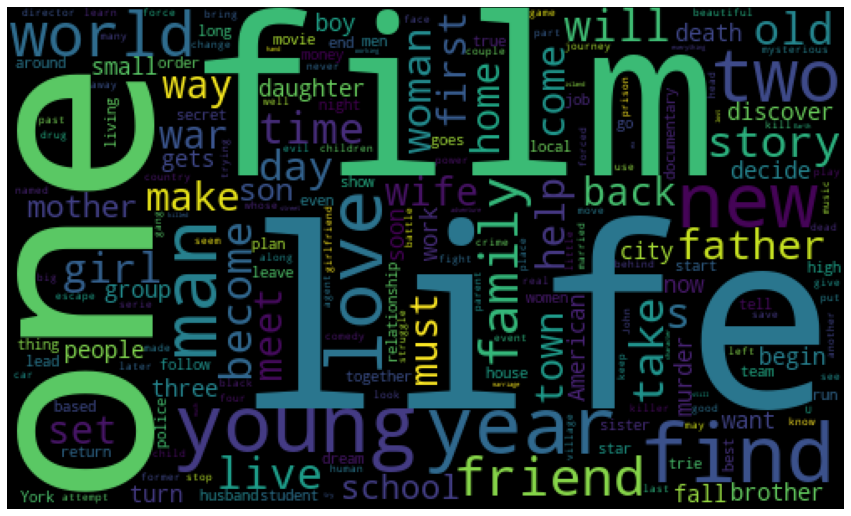

In [24]:
# see word cloud represention of words in movie overview

from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS

plt.figure(figsize=(15,10))
text = content_df.overview.values
cloud = WordCloud(stopwords= STOPWORDS,background_color= 'black',
                collocations= False, width= 500,
                height= 300).generate(''.join([str(val) for val in text]))
plt.axis('off')
plt.imshow(cloud)

In [25]:
# preprocess overview texts 

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

nltk.download('stopwords')
STOPWORDS = stopwords.words('english')
stemmer = PorterStemmer()

def clean_text(text, lower = True, stem = False, stopwords = STOPWORDS):
    if lower:
        text = text.lower()
    #remove stopwords
    if len(stopwords):
        pattern = re.compile(r'\b(' + r"|".join(stopwords) + r")\b\s*")
        text = pattern.sub('', text)
    # Spacing and filters
    text = re.sub(
      r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text
    )  # add spacing between objects to be filtered
    text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()  # strip white space at the ends

    # Stemming
    if stem:
        text = " ".join([stemmer.stem(word, to_lowercase=lower) for word in text.split(" ")])

    return text

content_df['overview'] = content_df['overview'].fillna('').apply(clean_text)
content_df.head(5)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,id,title,overview
0,862,Toy Story,led woody andy toys live happily room andy bir...
1,8844,Jumanji,siblings judy peter discover enchanted board g...
2,15602,Grumpier Old Men,family wedding reignites ancient feud next doo...
3,31357,Waiting to Exhale,cheated mistreated stepped women holding breat...
4,11862,Father of the Bride Part II,george banks recovered daughter wedding receiv...


In [26]:
# create tf-idf matrix
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()

tfidf_matrix = tfidf.fit_transform(content_df['overview'])

tfidf_matrix.shape

(45466, 74538)

In [27]:
# compute similarity with sklearn's linear kernel

from sklearn.metrics.pairwise import linear_kernel
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

#Construct a reverse mapping of indices and movie titles, and drop duplicate titles, if any
indices = pd.Series(content_df.index, index=content_df['title']).drop_duplicates()

In [28]:
# Function that takes in movie title as input and gives recommendations 
def content_recommender(title, cosine_sim=cosine_sim, df=content_df, indices=indices):
    # Obtain the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    # And convert it into a list of tuples as described above
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the cosine similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies. Ignore the first movie.
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return df['title'].iloc[movie_indices]

In [29]:
# See content recommender in action
#Get recommendations for The Lion King
content_recommender('The Lion King')

34682    How the Lion Cub and the Turtle Sang a Song
9353                                The Lion King 1½
9115                  The Lion King 2: Simba's Pride
42829                                           Prey
25654                                 Fearless Fagan
17041                                   African Cats
27933              Massaï, les guerriers de la pluie
31439                   Michael Jackson: Number Ones
22720                               Man of the World
6094                                       Born Free
Name: title, dtype: object

### Collaborative Filtering

This is one of the mostly widely used recommender systems though it relies mainly on past data therefore only used for cases with a mature database. It leverages power of the community to give recommendations. 

The simple idea here is that if user A like movies 1 , 2, 3, 4 and user B also likes movies 1, 2, 3 then it canbe be said that there is high similarity between the movie tastes of A and B and therefore user B is likely to like movie 4. This describes a user based collaborative filtering, the inverse will referred to as item-based filtering.

For this problem we will be using the ratings dataframe.

In [30]:
#create copy of data to use at this stage
ratings_df = ratings.copy().drop('timestamp', axis = 1)
ratings_df.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


#### Create helper funtions to be used in this section 

In [31]:
# split the data into train and validation while making sure there is almost equal distribution of users in both
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

train_df, test_df = train_test_split(ratings_df, test_size = 0.2, stratify = ratings_df['userId'], random_state = 42)
print(f'{train_df.userId.nunique()}')
print(f'{test_df.userId.nunique()}')

671
671


In [32]:
# create function to evaluate models

def rmse(y_pred, y_true):
    return mean_squared_error(y_true, y_pred, squared=False)

In [36]:
#create a function that scores a model
def score(cf_model):
    y_pred = []
    id_pairs = zip(test_df['userId'], test_df['movieId'])
    y_pred = np.array([cf_model(user, movie) for user, movie in id_pairs])
    y_true = test_df['rating']
    return rmse(y_pred, y_true)

#### Base Model 1.

lets first build a base model that predicts mean rating by all users in the train set for all movies in the test set and evaluate its performance.

In [37]:
mean = train_df['rating'].mean()
def predict_mode(user_id, movie_id):
    return mean

In [38]:
# score the mode rating model
score(predict_mode)

1.0665989304282688

#### User-based CF

For this task we will  create a ratings matrix that maps each user to every movie. This canbe easily done with pivot table where the value of ith row and jth column is the rating given by user i on movie j.

In [39]:
r_matrix = train_df.pivot_table(values='rating', index='userId', columns='movieId')

r_matrix.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,160565,160567,160590,160718,161594,161918,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
r_matrix[3].mean()

3.09

#### Build a mean CF model.
This model takes a userId and a movieId and returns the mean ratings of all users who have rated that movie

In [41]:
def cf_mean_model(user_id, movie_id):
    # first check if that movie has been previously rated
    if movie_id in r_matrix:
        return r_matrix[movie_id].mean()
    else: # does not exist
        return mean # average rating of all movies

In [42]:
# score the cf_mean_model
score(cf_mean_model)

1.0046802434458548

Yay!! Thats was a little better than just using the overall mean

#### Build weighted mean cf model
one of the drawbacks of the current model above is that it doesnt take into consideration any information about the user. To combat that we will give higher weights to ratings from users similar to user in question while calculating the mean rating. This can be achieved by building a similarity matrix between users and use it as weights when calculating mean. Here is the formula below

$$r_{u, m} = \frac{\sum_{u^1, u^1 \ne u} sim(u, u^1) \cdot r_{u^1,m}}{\sum_{u^1, u^1 \ne u} \mid sim(u, u^1)\mid}$$

where r represents the rating given by user u to
movie m.



In [43]:
# get a cosine similaity matrix for the task
from sklearn.metrics.pairwise import cosine_similarity
# first fill null values in the ratings matrix
r_matrix_dummy = r_matrix.copy().fillna(0)
cosine_sim = cosine_similarity(r_matrix_dummy, r_matrix_dummy) # score users
#Convert into pandas dataframe 
cosine_sim = pd.DataFrame(cosine_sim, index=r_matrix.index, columns=r_matrix.index)
cosine_sim.head(10)

userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.000000,0.000000,0.083960,0.020849,0.000000,0.042437,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.003532,0.026310,0.000000,0.000000,0.000000,0.076933,0.000000,0.021406
2,0.000000,1.000000,0.103653,0.104806,0.048915,0.000000,0.168399,0.058895,0.079865,0.000000,...,0.346634,0.055640,0.061230,0.156603,0.366781,0.309186,0.076655,0.022562,0.137329,0.121835
3,0.000000,0.103653,1.000000,0.079368,0.099360,0.074033,0.121355,0.194082,0.077229,0.079670,...,0.158736,0.031495,0.129580,0.138790,0.177061,0.111061,0.100727,0.044965,0.089542,0.148852
4,0.083960,0.104806,0.079368,1.000000,0.104463,0.075259,0.259225,0.185557,0.026303,0.073650,...,0.099728,0.039267,0.088078,0.211982,0.125055,0.075960,0.042866,0.105799,0.059541,0.128330
5,0.020849,0.048915,0.099360,0.104463,1.000000,0.076084,0.085429,0.127062,0.073386,0.028155,...,0.138056,0.000000,0.129530,0.166789,0.111709,0.028608,0.021621,0.047518,0.039814,0.190608
6,0.000000,0.000000,0.074033,0.075259,0.076084,1.000000,0.000000,0.107400,0.009843,0.034523,...,0.015255,0.010972,0.095592,0.072158,0.000000,0.000000,0.000000,0.028919,0.022281,0.080762
7,0.042437,0.168399,0.121355,0.259225,0.085429,0.000000,1.000000,0.119051,0.029262,0.166028,...,0.158728,0.053004,0.104598,0.136117,0.178420,0.210737,0.073024,0.021493,0.066240,0.244973
8,0.000000,0.058895,0.194082,0.185557,0.127062,0.107400,0.119051,1.000000,0.107149,0.075258,...,0.122558,0.025412,0.192706,0.183884,0.048506,0.067688,0.068269,0.016745,0.176750,0.280931
9,0.000000,0.079865,0.077229,0.026303,0.073386,0.009843,0.029262,0.107149,1.000000,0.062236,...,0.060208,0.132458,0.050689,0.087760,0.037156,0.081612,0.190306,0.000000,0.291750,0.109042


In [44]:
def weighted_cf_model(user_id, movie_id,):
    
    if movie_id in r_matrix:
        #Get the similarity scores for the user in question with every other user
        sim_scores = cosine_sim[user_id]
        #Get the user ratings for the movie in question
        m_ratings = r_matrix[movie_id]
        
        #Extract the indices containing NaN in the m_ratings series
        idx = m_ratings[m_ratings.isnull()].index
        
        #Drop the NaN values from the m_ratings Series
        m_ratings = m_ratings.dropna()
        
        #Drop the corresponding cosine scores from the sim_scores series
        sim_scores = sim_scores.drop(idx)
        
        #Compute the final weighted mean
        if sim_scores.sum() != 0: # avoid zero div
            wmean_rating = np.dot(sim_scores, m_ratings)/ sim_scores.sum()
        else:
            wmean_rating = mean
    else:
        wmean_rating = mean
        
    return wmean_rating

In [45]:
score(weighted_cf_model)

0.9982018964953938

Again, this approach as expected performed better than all others

#### Model based CF 

We have not learned any parameters for all the previously build cf models and as such what we have built so far is called memory-based filters. We can use Surprise - a python package for building recommendation systems to build model based filters built on KNN models and Svd models.

Lets explore these approaches next

In [46]:
from surprise import Dataset
from surprise import Reader
from surprise import SVD,KNNBasic
from surprise.model_selection import cross_validate

In [47]:
reader = Reader()
dfsv = Dataset.load_from_df(ratings_df, reader)

In [48]:
# Using KNN Algo

knn = KNNBasic()

#Evaluate the performance in terms of RMSE
cross_validate(knn, dfsv, measures=['RMSE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9682  0.9610  0.9755  0.9677  0.9655  0.9676  0.0047  
Fit time          0.18    0.21    0.22    0.21    0.22    0.21    0.01    
Test time         1.87    1.69    1.71    1.71    1.72    1.74    0.06    


{'test_rmse': array([0.96823771, 0.96104085, 0.9755072 , 0.96767585, 0.96554642]),
 'fit_time': (0.18332648277282715,
  0.2092428207397461,
  0.21708273887634277,
  0.21264028549194336,
  0.2150864601135254),
 'test_time': (1.8656954765319824,
  1.6876401901245117,
  1.7087125778198242,
  1.7069547176361084,
  1.7233402729034424)}

In [49]:
## With SVD
svd = SVD()

#Evaluate the performance in terms of RMSE
cross_validate(svd, dfsv, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8893  0.9092  0.8968  0.8931  0.8990  0.8975  0.0067  
Fit time          5.76    5.83    5.78    5.86    5.99    5.84    0.08    
Test time         0.19    0.16    0.36    0.15    0.16    0.20    0.08    


{'test_rmse': array([0.889325  , 0.90921604, 0.89681469, 0.89312973, 0.89903805]),
 'fit_time': (5.75623345375061,
  5.826709747314453,
  5.776641368865967,
  5.86246657371521,
  5.9931135177612305),
 'test_time': (0.1920301914215088,
  0.15511012077331543,
  0.3576779365539551,
  0.15188169479370117,
  0.16176414489746094)}

We can see that the SVD model performed better than KNNBasic and also beats all our memory based approaches.

### DeepLeraning Approach to movie recommendation

This is another form of collaborative filtering-based model where we learn user and item embeddings using deep neural networks. The advantage of such model is that it can take in other meta data features and use them for better recommendations. This approach however heavily data dependent and resource intensive.

Lets use pytorch to train a deep learning-based recommender system using the ratings dataset


In [50]:
# import the required libraries

import torch 
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import pytorch_lightning as pl
from sklearn.preprocessing import LabelEncoder
import math

In [51]:
df = ratings.copy() # create cpy of ratings df
USERS = df.userId.values
MOVIES = df.movieId.values
df.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [52]:
# Build custom dataset class
class MovieDataset(Dataset):
    def __init__(self, df):
        self.users = df.userId.values
        self.movies = df.movieId.values
        self.ratings = df.rating.values
            
    def __len__(self):
        return len(self.users)
    
    def __getitem__(self, idx):
        return {
            'user' : torch.tensor(self.users[idx], dtype = torch.long),
            'movie' : torch.tensor(self.movies[idx], dtype = torch.long),
            'rating' : torch.tensor(self.ratings[idx], dtype = torch.float)
        }
            

In [57]:
#Preprocess and build data loader

# encode the user and movie_ids. 
user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()
user_encoder.fit(df.userId)
movie_encoder.fit(df.movieId)
df.userId = user_encoder.transform(df.userId)
df.movieId = movie_encoder.transform(df.movieId)

NUM_USER = df.userId.nunique()
NUM_MOVIE = df.movieId.nunique()

train_df, valid_df = train_test_split(df, test_size = 0.2, stratify= df.userId, random_state = 42)

train_dataset = MovieDataset(train_df)
valid_dataset = MovieDataset(valid_df)

train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True, num_workers = 4)
valid_loader = DataLoader(valid_dataset, batch_size=1024, shuffle=False, num_workers = 4)

In [58]:
# Build a lightning model
class RycModel(pl.LightningModule):
    def __init__(self, num_users, num_movies):
        super().__init__()
        self.user_embed = nn.Embedding(num_users, 32)
        self.movie_embed = nn.Embedding(num_movies, 32)
        self.out = nn.Linear(64, 1)
        
    def forward(self, users, movies):

        user_embeds = self.user_embed(users)
        movie_embeds = self.movie_embed(movies)
        output = torch.cat([user_embeds, movie_embeds], dim = 1)
        output = self.out(output)
        return output

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        user_input, item_input, ratings = batch['user'], batch['movie'], batch['rating']
        pred_ratings = self(user_input, item_input)
        loss = nn.MSELoss()(pred_ratings, ratings.view(-1, 1).float())
        self.log('train_loss', loss , prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        # this is the validation loop
        user_input, item_input, ratings = batch['user'], batch['movie'], batch['rating']
        pred_ratings = self(user_input, item_input)
        val_loss = nn.MSELoss()(pred_ratings, ratings.view(-1, 1).float())
        y_true = ratings.detach().cpu().numpy()
        y_pred = pred_ratings.detach().cpu().numpy()
        self.log('val_loss', val_loss , prog_bar=True)
        return {'val_loss': val_loss, 'logits':pred_ratings.detach(),'targets':ratings}
        
    def train_epoch_end(self,outputs):
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        print(f'epoch {trainer.current_epoch} training loss {avg_loss}')
        return {'train_loss': avg_loss} 
    
    def validation_epoch_end(self,outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        output_val = torch.cat([x['logits'] for x in outputs],dim=0).cpu().detach().numpy()
        target_val = torch.cat([x['targets'] for x in outputs],dim=0).cpu().detach().numpy()
        
        # print(output_val.shape)
        avg_score = rmse(output_val,target_val)
        print(f'epoch {trainer.current_epoch} validation loss {avg_loss}')
        print(f'epoch {trainer.current_epoch} validation score {avg_score}')
        
        return {'val_loss': avg_loss,'val_mcrmse':avg_score}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-2)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.4)

        lr_scheduler = {"scheduler": scheduler }
        return [optimizer], [lr_scheduler]
        #return optimizer    

In [59]:
model = RycModel(num_users = NUM_USER, num_movies=NUM_MOVIE) # initialize model


early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(callbacks=[early_stop_callback], max_epochs= 30) # accelerator='gpu', devices=1,
trainer.fit(model=model, train_dataloaders=train_loader,val_dataloaders= valid_loader)

Sanity Checking: 0it [00:00, ?it/s]

epoch 0 validation loss 14.300607681274414
epoch 0 validation score 3.7816145420074463


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

epoch 0 validation loss 1.033012866973877
epoch 0 validation score 1.0166136026382446


Validation: 0it [00:00, ?it/s]

epoch 1 validation loss 0.8827983140945435
epoch 1 validation score 0.9397390484809875


Validation: 0it [00:00, ?it/s]

epoch 2 validation loss 0.8512681126594543
epoch 2 validation score 0.9226824641227722


Validation: 0it [00:00, ?it/s]

epoch 3 validation loss 0.842771053314209
epoch 3 validation score 0.9179359674453735


Validation: 0it [00:00, ?it/s]

epoch 4 validation loss 0.8431634902954102
epoch 4 validation score 0.9179409146308899


Validation: 0it [00:00, ?it/s]

epoch 5 validation loss 0.8365476727485657
epoch 5 validation score 0.914677619934082


Validation: 0it [00:00, ?it/s]

epoch 6 validation loss 0.8368698358535767
epoch 6 validation score 0.914859414100647


Validation: 0it [00:00, ?it/s]

epoch 7 validation loss 0.8339357376098633
epoch 7 validation score 0.9130298495292664


Validation: 0it [00:00, ?it/s]

epoch 8 validation loss 0.8349453806877136
epoch 8 validation score 0.9135235548019409


Validation: 0it [00:00, ?it/s]

epoch 9 validation loss 0.8353508114814758
epoch 9 validation score 0.913561224937439


Validation: 0it [00:00, ?it/s]

epoch 10 validation loss 0.8385230302810669
epoch 10 validation score 0.9154065847396851


Validation: 0it [00:00, ?it/s]

epoch 11 validation loss 0.8343700170516968
epoch 11 validation score 0.913163959980011


Validation: 0it [00:00, ?it/s]

epoch 12 validation loss 0.8402344584465027
epoch 12 validation score 0.9162880778312683


Validation: 0it [00:00, ?it/s]

epoch 13 validation loss 0.8395347595214844
epoch 13 validation score 0.9159693717956543


Validation: 0it [00:00, ?it/s]

epoch 14 validation loss 0.8388603329658508
epoch 14 validation score 0.9154952764511108


Validation: 0it [00:00, ?it/s]

epoch 15 validation loss 0.8395999073982239
epoch 15 validation score 0.9159050583839417


Validation: 0it [00:00, ?it/s]

epoch 16 validation loss 0.839733898639679
epoch 16 validation score 0.9160626530647278


Validation: 0it [00:00, ?it/s]

epoch 17 validation loss 0.8396939039230347
epoch 17 validation score 0.9159942865371704


We can see the DL model beats all other models apart from svd, though with better hyperparameter tuning, schedulers etc can beat even the svd model. And it gets better with more and more data

In [60]:
# Fuction takes a userId and a movieId and return the rating 
# the user is likely to give for that particular movie using the DL mdel
def predict(user_id, movie_id):
    if (user_id in USERS) and (movie_id in MOVIES):
        user_id = torch.tensor(user_encoder.transform([user_id]), dtype = torch.long)
        movie_id = torch.tensor(movie_encoder.transform([movie_id]), dtype = torch.long)
        rating = trainer.model(user_id, movie_id)
        return rating.detach().cpu().numpy().item()
    else:
        print('There is no record for this particular user or movie')
        return -1

In [61]:
# score dl model on validation data

def halfrounder(x):
    '''Function takes a ratings and rounds it to the closest half'''
    frac, whole = math.modf(x)
    if frac > 0.7499999:
        a = 1
    elif frac < 0.25:
        a = 0
    else:
        a = 0.5
    return whole + a

Results_df = valid_df.copy().drop('timestamp', axis = 1)
Results_df['Estimated_Rating'] = Results_df.apply(lambda x : predict(x['userId'], x['movieId']), axis=1)
Results_df['Estimation_Rounded'] = Results_df.apply(lambda x: halfrounder(x.Estimated_Rating), axis=1)
Results_df['Error'] = abs(Results_df['rating'] - Results_df['Estimation_Rounded'])
Results_df.head()


,userId,movieId,rating,Estimated_Rating,Estimation_Rounded,Error
54691,390,249,1.0,3.289020,3.5,2.5
5486,29,1819,5.0,4.706044,4.5,0.5
69837,480,7206,4.0,3.273894,3.5,0.5
6425,33,1343,3.0,3.169539,3.0,0.0
65674,467,45,3.5,3.306410,3.5,0.0


### Hybrid Recommenders

Netflix, when you sign up recommends the most popular rated movies, and asks some initial questions which it can use to form a knowledge base. It also asks you to rate some movies and from there will get features to build your database. As your watch and watch more movies, your database gets more and more features which netflix uses for better CF recommendations. While watching a particular movie, it uses CB recommenders to get similar items to the movie you are seeing and use a CF model to re-rank those items. Such system is known as **Hybrid recommender systems** and it combines various types of recommenders in a way to explore the advantage of one model to combat the short fall of others. 
Hybrid recommender systems combines various types of recommenders in a way that explore the advantage of one model to combat the short fall of others. 

With the functions built up above, we can actually build a hybrid model for any use case. 

## The End